In [1]:
import sys, os

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support


import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sn

In [2]:
data = pd.read_csv('clean_bo3_tdrive.csv', encoding='utf-8', converters={'pre_routes':eval}, index_col=0)
data.reset_index(level=0, inplace=True)
data

,vehicle_id,p_start,p_temp,p_end,pre_routes,pre_regions,freq,label
0,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.7666, 39.8027)","(empty, empty, empty)","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",40460,False
1,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.72105, 39.81482000000001)","(empty, empty, x005)","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1720,False
2,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.70168, 39.8301)","(empty, empty, 何牌路)","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",1683,False
3,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.77232, 39.81688)","(empty, empty, 京塘路)","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",2142,False
4,7,"(116.76038, 39.79758)","(116.7666, 39.8027)","(116.68455, 39.90142)","(empty, empty, binhe_middle)","('dianzhuang_tongzhou', 'dianzhuang_tongzhou',...",91,False
...,...,...,...,...,...,...,...,...
7151,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.37373, 39.96672)","(south_zhongguancun_street, north_3rd_ring, no...","('wanliu_haidian', 'none_haidian', 'huayuanlu_...",10,True
7152,702,"(116.31534, 39.96547)","(116.34378, 39.96626)","(116.29485, 39.95866)","(south_zhongguancun_street, north_3rd_ring, ch...","('wanliu_haidian', 'none_haidian', '兰靛厂村_haidi...",10,True
7153,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.28478, 39.95682)","(north_3rd_ring, north_3rd_ring, 蓝靛厂东路)","('none_haidian', 'huayuanlu_subdistrict_xichen...",10,True
7154,702,"(116.34378, 39.96626)","(116.37373, 39.96672)","(116.31725, 39.95593)","(north_3rd_ring, north_3rd_ring, south_zhonggu...","('none_haidian', 'huayuanlu_subdistrict_xichen...",10,True


In [3]:
data['pre_routes'] = data['pre_routes'].apply(lambda x: list(x))
data['label'] = data['label'].apply(lambda label: -1 if label == False else 1)

print("N_normal: ",len(data[data['label']==-1]))
print("N_abnormal: ",len(data[data['label']==1]))
data['label'].describe()

N_normal:  3805
N_abnormal:  3351


count    7156.000000
mean       -0.063443
std         0.998055
min        -1.000000
25%        -1.000000
50%        -1.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

In [4]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling

X = np.array(data['pre_routes'].tolist())
y = np.array(data['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vectorizer.fit(X_train)

X_train.shape, X_test.shape, len(vectorizer.get_feature_names())

d:\pythonapp\v2\.envgps-v2\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((5367, 3), (1789, 3), 231)

# Active Learning

In [6]:
initial_idx = np.random.choice(range(len(X_train)), size=int(X_train.shape[0]*0.6), replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)



precision_test = []
recall_test = []
f1_test = []
acc_test = []

X_initial_mat = vectorizer.transform(X_initial)
X_pool_mat = vectorizer.transform(X_pool)
X_test_mat = vectorizer.transform(X_test)


n_initial = 100
n_queries = 50
clf = SVC(C=1.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)


learner = ActiveLearner(
    estimator=clf,
    query_strategy=entropy_sampling,
    X_training=X_initial_mat, y_training=y_initial
)

print(X_initial.shape, X_pool.shape, X_test.shape)

(3220, 3) (2147, 3) (1789, 3)


In [8]:
for i in range(n_queries):
#     print(X_pool_mat.shape)
    try:
        query_idx, query_instance = learner.query(X_pool_mat, n_instances=int(X_pool_mat.shape[0]/n_queries)+1)
    except:
        break

    y_new = y_pool[query_idx]
    learner.teach(X_pool_mat[query_idx], y_new)
    
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    X_pool_mat = vectorizer.transform(X_pool)
    
    y_pred = learner.predict(X_test_mat)

    precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred,average='macro')
    precision_test.append(precision)
    recall_test.append(recall)
    f1_test.append(fscore)
    acc_test.append(accuracy_score(y_test,y_pred))
    
    print('F1-score after query {n}: {acc:0.4f}'.format(n=i + 1, acc=f1_test[i]))


    
mean_precision_test = np.mean(precision_test)
mean_recall_test = np.mean(recall_test)
mean_f1_test = np.mean(f1_test)
mean_acc_test = np.mean(acc_test)

test_perfm = [mean_precision_test, mean_recall_test, mean_f1_test, mean_acc_test]

performance = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test'])
performance

F1-score after query 1: 0.8990
F1-score after query 2: 0.9029
F1-score after query 3: 0.9035
F1-score after query 4: 0.9069
F1-score after query 5: 0.9086
F1-score after query 6: 0.9080
F1-score after query 7: 0.9069
F1-score after query 8: 0.9069
F1-score after query 9: 0.9079
F1-score after query 10: 0.9085
F1-score after query 11: 0.9074
F1-score after query 12: 0.9074
F1-score after query 13: 0.9074
F1-score after query 14: 0.9079
F1-score after query 15: 0.9085
F1-score after query 16: 0.9096
F1-score after query 17: 0.9085
F1-score after query 18: 0.9085
F1-score after query 19: 0.9096
F1-score after query 20: 0.9096
F1-score after query 21: 0.9096
F1-score after query 22: 0.9096
F1-score after query 23: 0.9096
F1-score after query 24: 0.9096
F1-score after query 25: 0.9096
F1-score after query 26: 0.9091
F1-score after query 27: 0.9091
F1-score after query 28: 0.9097
F1-score after query 29: 0.9102
F1-score after query 30: 0.9102
F1-score after query 31: 0.9102
F1-score after qu

,precision,recall,f1-score,accuracy
test,0.917839,0.906103,0.909086,0.910553


In [9]:
test_perfm = [precision_test[-1], recall_test[-1], f1_test[-1], acc_test[-1]]
test_perfm_al = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_al'])
test_perfm_al

,precision,recall,f1-score,accuracy
test_al,0.919404,0.907853,0.910818,0.912241


# Machine Learning

In [12]:
X_train_mat = vectorizer.transform(X_train)
X_test_mat = vectorizer.transform(X_test)

clf = SVC(C=1.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)
clf.fit(X_train_mat, y_train)

y_pred_ml = clf.predict(X_test_mat)
ml_precision, ml_recall, ml_fscore, ml_support = precision_recall_fscore_support(y_test,y_pred_ml,average='macro')

ml_acc = accuracy_score(y_test,y_pred_ml)
print(fscore)
test_perfm_ml = pd.DataFrame([[ml_precision,ml_recall,ml_fscore, ml_acc]], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_ml'])
test_perfm_ml

0.9108182552798986


,precision,recall,f1-score,accuracy
test_ml,0.919404,0.907853,0.910818,0.912241


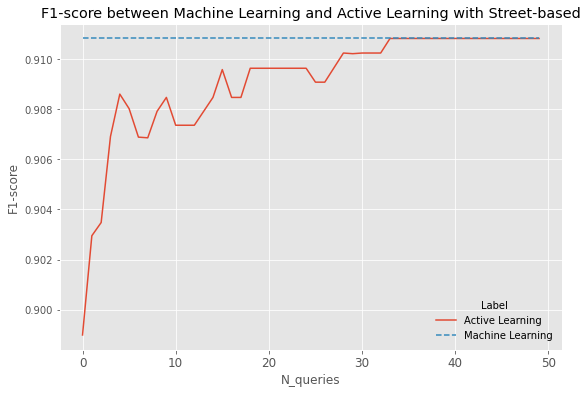

In [13]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.rcParams['xtick.labelsize'] = 12
plt.plot(range(len(f1_test)),f1_test, label='Active Learning')
plt.plot(range(len(f1_test)),[ml_fscore]*n_queries, '--',label='Machine Learning')
plt.xlabel('N_queries')
plt.ylabel('F1-score')
plt.legend(loc="lower right", title="Label", frameon=False)
plt.title("F1-score between Machine Learning and Active Learning with Street-based")
plt.show()